# Projet 7 : Réalisez une analyse de sentiments grâce au Deep Learning
# Modèle avancé BERT

[Lien OpenClassroom](https://openclassrooms.com/fr/paths/795/projects/1516/1578-mission)

---

**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_)    
- [Chargement des données](#toc2_)    
  - [Chargement du fichier csv](#toc2_1_)    
  - [Découpage du jeu de données](#toc2_2_)    
- [Préparation pour BERT](#toc3_)    
  - [Création d'un Tokenizer](#toc3_1_)    
  - [Construction modèle BERT pour Classification](#toc3_2_)    
- [Entrainement](#toc4_)    
  - [MLFlow Setup](#toc4_1_)    
  - [Entrainement du modèle avec MLFlow](#toc4_2_)    
- [Evaluation du modèle sur les données de Test](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---
---

## <a id='toc1_'></a>[Imports](#toc0_)

In [ ]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
import mlflow
import logging
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns

tf.get_logger().setLevel(logging.ERROR)
logging.getLogger("transformers").setLevel(logging.ERROR)

---
---

## <a id='toc2_'></a>[Chargement des données](#toc0_)

---

### <a id='toc2_1_'></a>[Chargement du fichier csv](#toc0_)

In [ ]:
DATA_PATH = "./data.csv"

df = (
    pd.read_csv(DATA_PATH)
    .groupby("label", group_keys=False)
    .apply(lambda x: x.sample(10000))
)

df

C:\Users\LeBonCassoulet\AppData\Local\Temp\ipykernel_16144\4194022013.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = pd.read_csv(DATA_PATH).groupby('label', group_keys=False).apply(lambda x: x.sample(10000))


,tweet,label
70370,is ready for workk... Bleuugh!,0
346544,20 more minutes???,0
161135,"meh, almost didn't sleep, ain't finished anyth...",0
654673,i have a friggin headache,0
612066,i'm freakin tired and it's only 10am... not a ...,0
...,...,...
1522749,"Just called 911 in this passed out, drunk dude...",1
1576259,*tweet* *tweet* i'm eating delicious nuggets w...,1
1012112,@nancetron I shall stick that on my spotify ch...,1
1281716,@taylorswift13 http://twitpic.com/6g8k2 - gorg...,1


---

### <a id='toc2_2_'></a>[Découpage du jeu de données](#toc0_)

Cette cellule de code est responsable de la division du jeu de données original en trois sous-ensembles distincts : entraînement, validation et test. La séparation est effectuée en deux étapes successives pour garantir des proportions spécifiques (ici 15% pour la validation et 15% pour le test, le reste pour l'entraînement). L'utilisation de stratify=y assure que la distribution des classes (sentiments) est préservée de manière égale dans chacun des ensembles, ce qui est crucial pour les problèmes de classification. Enfin, les dimensions de chaque ensemble et la distribution des classes sont affichées pour vérification.

In [3]:
X = df["tweet"]  # Caractéristiques (le texte du tweet)
y = df["label"]  # Cible (le sentiment associé au tweet)

# Définition des ratios de séparation des données
TEST_SIZE = 0.15  # Taille de l'ensemble de test (15% de l'original)
VALIDATION_SIZE = 0.15  # Taille de l'ensemble de validation (15% de l'original)

# Première séparation : Ensemble d'entraînement vs. (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=(VALIDATION_SIZE + TEST_SIZE),  # La taille combinée pour temp
    random_state=42,  # Pour la reproductibilité des résultats
    stratify=y,  # Maintient la proportion des classes dans les splits
)

# Calcul du ratio pour séparer l'ensemble temporaire en validation et test
# Ce ratio est relatif à la taille de X_temp
val_split_ratio = VALIDATION_SIZE / (VALIDATION_SIZE + TEST_SIZE)

# Deuxième séparation : Validation vs. Test à partir de l'ensemble temporaire
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=(1 - val_split_ratio),  # Le reste de X_temp est alloué au test
    random_state=42,
    stratify=y_temp,  # Maintient la proportion des classes dans ces splits
)

print("Séparation des données terminée :")
print(f"Forme de l'ensemble d'entraînement :   X={X_train.shape}, y={y_train.shape}")
print(f"Forme de l'ensemble de validation : X={X_val.shape}, y={y_val.shape}")
print(f"Forme de l'ensemble de test :       X={X_test.shape}, y={y_test.shape}")

print("\nDistribution des sentiments dans les ensembles :")
print("Entraînement :\n", y_train.value_counts(normalize=True))
print("Validation :\n", y_val.value_counts(normalize=True))
print("Test :\n", y_test.value_counts(normalize=True))

Séparation des données terminée :
Forme de l'ensemble d'entraînement :   X=(14000,), y=(14000,)
Forme de l'ensemble de validation : X=(3000,), y=(3000,)
Forme de l'ensemble de test :       X=(3000,), y=(3000,)

Distribution des sentiments dans les ensembles :
Entraînement :
 label
0    0.5
1    0.5
Name: proportion, dtype: float64
Validation :
 label
0    0.5
1    0.5
Name: proportion, dtype: float64
Test :
 label
1    0.5
0    0.5
Name: proportion, dtype: float64


---
---

## <a id='toc3_'></a>[Préparation pour BERT](#toc0_)

Cette cellule initialise l'environnement MLflow en définissant le nom de l'expérience sous laquelle les exécutions (runs) et leurs métriques seront enregistrées. Elle établit également un ensemble de paramètres clés qui seront utilisés pour la configuration du modèle BERT et le processus d'entraînement. Ces paramètres incluent le nom spécifique du modèle BERT pré-entraîné, la longueur maximale des séquences, la taille des lots, le nombre d'époques d'entraînement et le taux d'apprentissage.

In [4]:
# Définit le nom de l'expérience MLflow
EXPERIMENT_NAME = "Tweet Sentiment Analysis - BERT Models"
mlflow.set_experiment(EXPERIMENT_NAME)
print(f"Expérience MLflow : {EXPERIMENT_NAME}")

# --- 1. Paramètres et Données ---

# Nom du modèle BERT pré-entraîné à utiliser
MODEL_NAME = "bert-base-uncased"
# Longueur maximale des séquences de tokens après tokenisation
MAX_LENGTH = 16
# Taille du lot (batch) pour l'entraînement du modèle
BATCH_SIZE = 16
# Nombre d'époques pour l'entraînement
EPOCHS = 6
# Taux d'apprentissage pour l'optimiseur
LEARNING_RATE = 0.0001

Expérience MLflow : Tweet Sentiment Analysis - BERT Models


---

### <a id='toc3_1_'></a>[Création d'un Tokenizer](#toc0_)

Cette cellule gère la préparation des données textuelles pour le modèle BERT. Elle initialise un BertTokenizer basé sur le modèle choisi (MODEL_NAME) pour convertir le texte brut en un format numérique compréhensible par le modèle (IDs de tokens, masques d'attention). Une fonction encode_texts est définie pour appliquer cette tokenisation aux ensembles d'entraînement, de validation et de test, en gérant la troncature et le padding. Enfin, les données encodées sont transformées en objets tf.data.Dataset optimisés pour l'entraînement avec TensorFlow, en intégrant le mélange des données (shuffle), le regroupement par lots (batch) et le pré-chargement (prefetch) pour améliorer les performances. Un exemple de l'encodage est affiché pour vérification.

In [ ]:
# Initialisation du tokenizer spécifique au modèle BERT choisi
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)


# Fonction pour encoder une liste de textes
def encode_texts(texts):
    return tokenizer(
        texts,
        max_length=MAX_LENGTH,  # Longueur maximale pour toutes les séquences
        truncation=True,  # Tronque les séquences plus longues
        padding="max_length",  # Ajoute du padding pour atteindre max_length
        return_attention_mask=True,  # Retourne le masque d'attention
        return_token_type_ids=False,  # N'est pas nécessaire pour une seule séquence
        return_tensors="tf",  # Retourne des tenseurs TensorFlow
    )


# Encodage des ensembles d'entraînement, de validation et de test
train_encodings = encode_texts(X_train.tolist())
val_encodings = encode_texts(X_val.tolist())
test_encodings = encode_texts(X_test.tolist())

# Conversion des données encodées en objets tf.data.Dataset pour un traitement efficace
# L'ensemble d'entraînement est mélangé (shuffle)
train_dataset = (
    tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
    .shuffle(len(X_train))  # Mélange les données pour l'entraînement
    .batch(BATCH_SIZE)  # Regroupe les données en lots
    .prefetch(tf.data.AUTOTUNE)  # Préfetche les lots pour améliorer les performances
)

# Les ensembles de validation et de test sont regroupés en lots et préfetchés
val_dataset = (
    tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("\nExemple d'encodage (première phrase d'entraînement) :")
# Affiche les 10 premiers tokens et l'attention mask de la première séquence encodée
for key, value in train_encodings.items():
    print(f"{key}: {value[0].numpy().tolist()[:10]}...")


Exemple d'encodage (première phrase d'entraînement) :
input_ids: [101, 2064, 1005, 1056, 3637, 2074, 3786, 14181, 2050, 1998]...
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...


---

### <a id='toc3_2_'></a>[Construction modèle BERT pour Classification](#toc0_)

Cette cellule est responsable de la construction et de la préparation du modèle de classification. Elle charge un modèle BERT pré-entraîné (TFBertForSequenceClassification) adapté à une tâche de classification binaire. Ensuite, elle compile le modèle en spécifiant l'optimiseur (Adam), la fonction de perte (SparseCategoricalCrossentropy) et la métrique d'évaluation (accuracy). Enfin, elle prépare les tf.data.Dataset pour l'entraînement et le test en appliquant des opérations de mélange (shuffle) pour l'entraînement et de regroupement par lots (batch) pour les deux ensembles, facilitant ainsi l'efficacité de l'entraînement du modèle.

In [6]:
# Chargement du modèle BERT pré-entraîné pour la classification de séquences
# `num_labels=2` indique qu'il s'agit d'une tâche de classification binaire (par exemple, sentiment positif/négatif)
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Compilation du modèle pour l'entraînement
optimizer = Adam(
    learning_rate=2e-5
)  # Optimiseur Adam avec un taux d'apprentissage spécifique
loss = SparseCategoricalCrossentropy(
    from_logits=True
)  # Fonction de perte adaptée aux sorties logit du modèle
model.compile(
    optimizer=optimizer, loss=loss, metrics=["accuracy"]
)  # Compile le modèle avec l'optimiseur, la perte et la métrique

# Préparation des ensembles de données TensorFlow (Dataset)
# L'ensemble d'entraînement est mélangé et divisé en lots
train_dataset = (
    tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
    .shuffle(1000)  # Mélange les données
    .batch(16)  # Crée des lots de 16 exemples
)

# L'ensemble de test est divisé en lots
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test)).batch(
    16
)

---
---

## <a id='toc4_'></a>[Entrainement](#toc0_)

---

### <a id='toc4_1_'></a>[MLFlow Setup](#toc0_)

In [ ]:
# Nom de l'expérience MLflow pour organiser les exécutions
EXPERIMENT_NAME = "Tweet Sentiment Analysis - BERT Models"

# Définit l'expérience MLflow active


mlflow.set_experiment(EXPERIMENT_NAME)
print(f"Expérience MLflow définie sur : '{EXPERIMENT_NAME}'")

# Chemin où l'artefact du modèle BERT sera enregistré dans MLflow


MODEL_ARTIFACT_PATH_BERT = "bert-model"

Expérience MLflow définie sur : 'Tweet Sentiment Analysis - BERT Models'


---

### <a id='toc4_2_'></a>[Entrainement du modèle avec MLFlow](#toc0_)

Cette cellule orchestre le processus complet d'entraînement et d'évaluation du modèle de classification de sentiment, en intégrant le suivi avec MLflow. Elle démarre une nouvelle exécution MLflow pour laquelle elle loggue tous les hyperparamètres et les tailles des ensembles de données. Le modèle est ensuite entraîné sur l'ensemble d'entraînement et validé sur l'ensemble de validation. Après l'entraînement, une évaluation finale est réalisée sur l'ensemble de test, et les métriques de performance obtenues (perte et précision) sont enregistrées. Enfin, le modèle entraîné ainsi que son tokenizer associé sont sauvegardés en tant qu'artefact dans l'exécution MLflow, assurant une traçabilité complète et la reproductibilité des résultats.

In [8]:
# Démarre une nouvelle exécution MLflow pour suivre l'entraînement du modèle
with mlflow.start_run(run_name="BERT") as run:
    # Enregistrement des hyperparamètres et des tailles des ensembles de données
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_param("max_length", MAX_LENGTH)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("train_samples", len(X_train))
    mlflow.log_param("val_samples", len(X_val))
    mlflow.log_param("test_samples", len(X_test))

    print("\n--- Démarrage de l'entraînement ---")
    # Active l'autologging pour TensorFlow, en désactivant la journalisation automatique du modèle,
    # des exemples d'entrée et des signatures de modèle pour un contrôle manuel
    mlflow.tensorflow.autolog(
        log_models=False,
        log_input_examples=False,
        log_model_signatures=False,
    )

    # Entraînement du modèle avec les ensembles de données d'entraînement et de validation
    history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)
    print("--- Entraînement terminé ---")

    # --- 5. Évaluation ---
    print("\n--- Évaluation sur l'ensemble de test ---")
    # Évaluation du modèle sur l'ensemble de test
    results = model.evaluate(test_dataset, batch_size=BATCH_SIZE, return_dict=True)
    print(f"Résultats du test : {results}")
    # Enregistrement des métriques de perte et de précision du test dans MLflow
    mlflow.log_metrics(
        {"test_loss": results["loss"], "test_accuracy": results["accuracy"]}
    )

    # --- 6. Sauvegarde du Modèle et du Tokenizer avec MLflow ---

    print("\n--- Sauvegarde du modèle et du tokenizer avec MLflow ---")
    # Enregistrement du modèle et du tokenizer en tant qu'artefact MLflow
    mlflow.transformers.log_model(
        transformers_model={
            "model": model,
            "tokenizer": tokenizer,
        },
        artifact_path="bert_sentiment_model",  # Chemin où l'artefact sera enregistré
        input_example=X_train[:5],  # Exemple d'entrée pour la signature du modèle
    )

    # Affichage de l'ID de l'exécution MLflow
    print(f"ID de l'exécution MLflow : {run.info.run_id}")
    print(
        f"Modèle et Tokenizer sauvegardés dans l'exécution MLflow sous 'bert_sentiment_model'"
    )

2025/06/17 21:07:33 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "tf_bert_for_sequence_classification" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.



--- Démarrage de l'entraînement ---
Epoch 1/6
875/875 [==============================] - 534s 594ms/step - loss: 0.5344 - accuracy: 0.7281 - val_loss: 0.5076 - val_accuracy: 0.7530
Epoch 2/6
875/875 [==============================] - 515s 589ms/step - loss: 0.4047 - accuracy: 0.8211 - val_loss: 0.5466 - val_accuracy: 0.7593
Epoch 3/6
875/875 [==============================] - 513s 586ms/step - loss: 0.2508 - accuracy: 0.8989 - val_loss: 0.6871 - val_accuracy: 0.7357
Epoch 4/6
875/875 [==============================] - 512s 585ms/step - loss: 0.1422 - accuracy: 0.9470 - val_loss: 0.8408 - val_accuracy: 0.7297
Epoch 5/6
875/875 [==============================] - 510s 582ms/step - loss: 0.0882 - accuracy: 0.9682 - val_loss: 1.0840 - val_accuracy: 0.7250
Epoch 6/6
875/875 [==============================] - 500s 572ms/step - loss: 0.0561 - accuracy: 0.9806 - val_loss: 1.2003 - val_accuracy: 0.7233


2025/06/17 21:58:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='16' for run ID='87965c3e84de41cbb3d067c6073d57b1'. Attempted logging new value 'None'.


--- Entraînement terminé ---

--- Évaluation sur l'ensemble de test ---
188/188 [==============================] - 24s 127ms/step - loss: 1.1333 - accuracy: 0.7407
Résultats du test : {'loss': 1.1332744359970093, 'accuracy': 0.7406666874885559}

--- Sauvegarde du modèle et du tokenizer avec MLflow ---


MlflowException: Expected one of the following types:
- pandas.DataFrame
- numpy.ndarray
- dictionary of (name -> numpy.ndarray)
- scipy.sparse.csr_matrix
- scipy.sparse.csc_matrix
- dict
- list
- scalars
- datetime.datetime
- pydantic model instance
but got '<class 'pandas.core.series.Series'>'

---
---

## <a id='toc5_'></a>[Evaluation du modèle sur les données de Test](#toc0_)

Cette cellule illustre l'utilisation du modèle entraîné pour effectuer des prédictions sur de nouvelles données. Elle commence par tokeniser un échantillon de tweets de l'ensemble de test. Ensuite, elle utilise le modèle pour obtenir les logits (sorties brutes) des prédictions, les convertit en probabilités de classe à l'aide de la fonction softmax, puis détermine la classe prédite (le sentiment) en sélectionnant la classe avec la probabilité la plus élevée. Enfin, elle affiche, pour les tweets de l'échantillon, le tweet original, les probabilités prédites pour chaque classe, le sentiment prédit, et le sentiment réel pour comparaison.


--- Exemple de prédiction avec le modèle chargé depuis MLflow ---
94/94 [==============================] - 19s 200ms/step
Précision de test : 0.7226
Rappel de test : 0.7813
Score F1 de test : 0.7508

Rapport de classification (ensemble de test) :
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1500
           1       0.72      0.78      0.75      1500

    accuracy                           0.74      3000
   macro avg       0.74      0.74      0.74      3000
weighted avg       0.74      0.74      0.74      3000


Matrice de confusion (ensemble de test) :


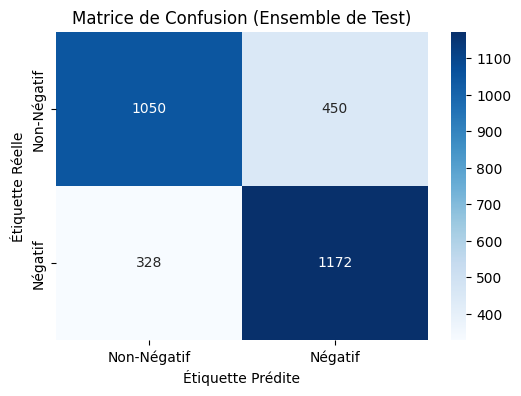


Tweet: What a lovely day.  Full body massage, then shopping for face cloths &amp; over the door hook, then had lunch and spent time with friends. #fb
  Probabilités (Négatif, Non-Négatif/Positif): [0.06556845 0.93443155]
  Sentiment Prédit: Non-Négatif/Positif | 'Vrai' Sentiment : 1

Tweet: @DevilsRefugee bring back the 80s I say! 
  Probabilités (Négatif, Non-Négatif/Positif): [4.0343750e-04 9.9959654e-01]
  Sentiment Prédit: Non-Négatif/Positif | 'Vrai' Sentiment : 1

Tweet: Cola gummy candies taste nice at night  - http://tweet.sg
  Probabilités (Négatif, Non-Négatif/Positif): [0.03343665 0.96656334]
  Sentiment Prédit: Non-Négatif/Positif | 'Vrai' Sentiment : 1

Tweet: @simonelrp: Potter, are also in that category! Hehe. &lt;3 I love you too!!! So much 
  Probabilités (Négatif, Non-Négatif/Positif): [4.4560962e-04 9.9955434e-01]
  Sentiment Prédit: Non-Négatif/Positif | 'Vrai' Sentiment : 1

Tweet: I just arrived in the office.. I am preparing myself for a very busy day, listening

In [ ]:
print("\n--- Exemple de prédiction avec le modèle chargé depuis MLflow ---")

# Tokenisation des exemples du jeu de test
sample_encodings = encode_texts(X_test.tolist())

# Obtention des prédictions (logits) du modèle
predictions = model.predict(dict(sample_encodings))
logits = predictions.logits

test_precision = precision_score(
    y_test, [np.argmax(pred) for pred in logits], zero_division=0
)
test_recall = recall_score(
    y_test, [np.argmax(pred) for pred in logits], zero_division=0
)
test_f1 = f1_score(y_test, [np.argmax(pred) for pred in logits], zero_division=0)

print(f"Précision de test : {test_precision:.4f}")
print(f"Rappel de test : {test_recall:.4f}")
print(f"Score F1 de test : {test_f1:.4f}")

print("\nRapport de classification (ensemble de test) :")
print(classification_report(y_test, [np.argmax(pred) for pred in logits]))

print("\nMatrice de confusion (ensemble de test) :")
# Calcul et affichage de la matrice de confusion
cm = confusion_matrix(y_test, [np.argmax(pred) for pred in logits])
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non-Négatif", "Négatif"],
    yticklabels=["Non-Négatif", "Négatif"],
)
plt.xlabel("Étiquette Prédite")
plt.ylabel("Étiquette Réelle")
plt.title("Matrice de Confusion (Ensemble de Test)")
plt.show()

# Conversion des logits en probabilités (via softmax) et détermination des classes prédites
probabilities = tf.nn.softmax(logits, axis=-1).numpy()
predicted_classes = np.argmax(
    probabilities, axis=1
)  # Sélectionne l'indice de la probabilité maximale

# Affichage des prédictions de l'ensemble de test
for tweet, true, prob, pred_class in zip(
    X_test, y_test, probabilities, predicted_classes
):
    # Détermine l'étiquette de sentiment lisible
    sentiment = "Non-Négatif/Positif" if pred_class == 1 else "Négatif"
    print(f"\nTweet: {tweet}")
    print(f"  Probabilités (Négatif, Non-Négatif/Positif): {prob}")
    print(f"  Sentiment Prédit: {sentiment} | 'Vrai' Sentiment : {true}")